In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [118]:
import pandas as pd
import numpy  as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO

from int.int_env     import IntEnv
from unint.unint_env import UnintEnv
from hvac.hvac_env   import HVAC_env
from soc.soc_env     import SocEnv

class HLA_Env(gym.Env):
    def __init__(self, mode = 'train'):
        super(HLA_Env, self).__init__()
        self.mode = mode # train or test
        self.Pgrid_max   = None
        self.time_step   = None
        self.action_mask = None
        self.agent_order = None
        self.month       = None
        self.month_name  = None
        self.month_name_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dcb']

        # step data
        self.now_Pgrid_price  = None
        self.now_remain_power = None

        #episode data
        self.execute_price_data = None
        self.execute_remain_power_data = None
        
        # read data
        self.price_data = pd.read_csv("csv_data/grid_price.csv")   # ['summer_price'] ['not_summer_price']
        self.pv_data    = pd.read_csv("csv_data/PhotoVoltaic.csv") # ['month']

        if self.mode == 'train':
            self.unc_power_data = pd.read_csv("csv_data/TrainingData.csv")
        else:
            self.unc_power_data = pd.read_csv("csv_data/TestingData.csv") 

        # model ---------------------------------
        self.soc_model        = PPO.load("soc/agent/soc_model_f")
        self.int_load_model   = PPO.load("int/agent/int_model_f")
        self.unint_load_model = PPO.load("unint/agent/unint_model_f")
        self.hvac_model       = PPO.load("hvac/agent/hvac_model_f")

        # int load data
        self.execute_int_load_preference_data = {}

        self.int_load_preference_data = {
            1 : pd.read_csv("csv_data/intPreference1.csv"),
            2 : pd.read_csv("csv_data/intPreference2.csv"),
            3 : pd.read_csv("csv_data/intPreference3.csv")
        }

        # unint load data
        self.unint_load_already_add = { 1 : False, 2 : False }

        self.execute_unint_load_preference_data = {}
        
        self.unint_load_preference_data = {
            1 : pd.read_csv("csv_data/unIntPreference1.csv"),
            2 : pd.read_csv("csv_data/unIntPreference2.csv")
        }

        # hvac ---------------------------------
        self.T_out_data = pd.read_csv("csv_data/TemperatureF.csv")

        self.T_set_data = {
            1 : pd.read_csv("csv_data/userSetTemperatureF.csv"),
            2 : pd.read_csv("csv_data/userSetTemperatureF2.csv"),
            3 : pd.read_csv("csv_data/userSetTemperatureF3.csv")
        }

        # load data 
        self.soc_load   = None
        self.hvac_load  = {}
        self.int_load   = {}
        self.unint_load = {}

        # for testing
        self.total_cost = 0
        self.total_preference = 0

        # save print data
        self.plt_data = {}
        self.already_open_order = { agent : 1 for agent in ['soc','int_1','int_2','int_3','unint_1','unint_2','hvac_1','hvac_2','hvac_3']}

        # observation space [ time_step, SOC, remain_power, order, pgrid_price, state, power, preference]
        lowerLimit = np.array(
            [
                # time_step
                0,
                # remain_power
                -20,
                # pgrid_price
                0,
                # order
                # 0,
                #T_out
                35,
                #SOC
                -0.5,
                # load order
                0, 

                # Int_load_1 
                0, # remain_demand
                0, # power
                -1,# preference
                0, # load order

                # Int_load_2_state
                0, # remain_demand
                0, # power
                -1,# preference
                0, # load order

                # Int_load_3_state
                0, # remain_demand
                0, # power
                -1,# preference
                0, # load order

                # Unint_load_1_state
                0,  # remain_demand
                0,  # period
                0,  # remain_period
                0,  # power
                -1, # preference
                0,  # load order

                # Unint_load_2_state
                0,  # remain_demand
                0,  # period
                0,  # remain_period
                0,  # power
                -1, # preference
                0,  # load order

                # HVAC 1
                20, # T_in
                35, # T_user_set
                0,  # load order

                # HVAC 2
                20, # T_in
                35, # T_user_set
                0,  # load order

                # HVAC 3
                20, # T_in
                35, # T_user_set
                0,  # load order

            ], 
            dtype=np.float32
        )

        upperLimit = np.array(
            [
                # time_step
                96,
                # remain_power
                30,
                # pgrid_price
                7,
                # order
                # 9,
                # T_out
                130,
                # SOC
                1.5,
                # load order
                9,  

                # Int_load_1 
                40, # remain_demand
                5,  # power
                4,  # preference
                9,  # load order

                # Int_load_2_state
                40, # remain_demand
                5,  # power
                4,  # preference
                9,  # load order

                # Int_load_3_state
                40, # remain_demand
                5,  # power
                4,  # preference
                9,  # load order

                # Unint_load_1_state
                40, # remain_demand
                7,  # period
                7,  # remain_period
                5,  # power
                4,  # preference
                9,  # load order

                # Unint_load_2_state
                40, # remain_demand
                7,  # period
                7,  # remain_period
                5,  # power
                4,  # preference
                9,  # load order

                # HVAC 1
                130, # T_in
                130, # T_set
                9,   # load order

                # HVAC 2
                130, # T_in
                130, # T_set
                9,   # load order

                # HVAC 3
                130, # T_in
                130, # T_set
                9,   # load order

            ], 
            dtype=np.float32
        )

        self.observation_space = spaces.Box(lowerLimit, upperLimit, dtype=np.float32)
        # Ation space --------------------------------------------------------------------------------------
        self.action_space = spaces.Discrete(9)

    def action_masks(self):
        return self.action_mask
    
    def _soc_interact(self):
        fixload = ( self.Pgrid_max - self.now_remain_power )
        state   = np.array([ self.time_step, fixload, self.soc_load.soc, self.now_Pgrid_price]) # [time_step, remian_power, soc, pgrid_price]
        self.soc_load.state = state
        action, _ = self.soc_model.predict(state, deterministic=True)
        _ = self.soc_load.step(action)

        power = self.soc_load.load_use_power
        preference = 0
        reward = self.soc_load.reward

        if self.mode != 'train':
            self.plt_data['soc'].append(self.soc_load.soc)
            self.plt_data['soc_action'].append(power)
            self.plt_data['soc_fixload'].append(fixload)
        
            # if self.mode == 'test_print':
            #     print('soc     - action {: .2f}  | use power {:} | reward {:}'.format( float(action[0]), power, reward ) )
            #     print(self.soc_load.state)
            #     print()

        return power, preference, reward

    def _int_load_interact(self, id):
        remain_power  = self.now_remain_power - self.int_load[id].load_power
        remain_demand = self.int_load[id].load_remain_demand
        preference    = self.execute_int_load_preference_data[id][self.time_step]
        
        #[ time_step, pgrid_price, remain_time, preference]
        state = np.array([ self.time_step, self.now_Pgrid_price, remain_demand, preference])
        self.int_load[id].state = state 
        
        if remain_power >= 0:
            action, _  = self.int_load_model.predict(state, deterministic=True)
        else:
            action = 0

        print(action)

        _ = self.int_load[id].step(action)

        power      = self.int_load[id].load_use_power
        preference = self.int_load[id].load_preference
        reward     = self.int_load[id].reward

        if self.mode != 'train':
            self.plt_data['int_'+str(id)+'_power'].append(power)
            self.plt_data['int_'+str(id)+'_fixload'].append(self.Pgrid_max-self.now_remain_power)

            # if self.mode == 'test_print':
            #     print('int {:}   - action {: .2f}  | use power {:} | reward {:}'.format(id, float(action), power, reward ) )
            #     print(self.int_load[id].state)
            #     print()

        return power, preference, reward
    
    def _unint_load_interact(self, id):
        remain_power = self.now_remain_power - self.unint_load[id].load_power
        preference   = self.execute_unint_load_preference_data[id][self.time_step]
        
        # [ time_step, pgrid_price, remain_time, remain_period, period_len, preference ]
        state = np.array([ self.time_step, self.now_Pgrid_price, self.unint_load[id].load_remain_demand,  self.unint_load[id].load_remain_period, self.unint_load[id].load_period, preference ])
        self.unint_load[id].state = state 

        if remain_power >= 0:
            action, _  = self.unint_load_model.predict(state, deterministic=True)
        else:
            action = 0

        if ( id == 2 ) and ( self.time_step == 68 or self.time_step == 69 ):
            action = 0
        
        _ = self.unint_load[id].step(action)

        power      = self.unint_load[id].load_use_power
        preference = self.unint_load[id].load_preference
        reward     = self.unint_load[id].reward

        if self.unint_load_already_add[id] == True:
            already_remain_power = self.unint_load[id].load_power
            power = 0
        else:
            already_remain_power = 0

        if self.mode != 'train':
            self.plt_data['unint_'+str(id)+'_power'].append(self.unint_load[id].load_use_power)
            self.plt_data['unint_'+str(id)+'_fixload'].append(self.Pgrid_max - self.now_remain_power - already_remain_power)

            if self.mode == 'test_print':
                print('unint {:} - action {: .2f}  | use power {:} | reward {:}'.format(id, float(action), power, reward ) )
                print(self.unint_load[id].state)
                print()

        return power, preference, reward
    
    def _hvac_interact(self, id):
        
        remain_power = min( self.hvac_load[id].load_power, self.now_remain_power )
        T_in  = self.hvac_load[id].T_in
        T_out = self.execute_T_out[self.time_step]
        T_set = self.execute_hvac_T_set_data[id][self.time_step]
        
        # [ time_step, remain_power, price, T_in, T_out, T_set ]
        state = np.array([ self.time_step, remain_power, self.now_Pgrid_price, T_in, T_out, T_set])

        self.hvac_load[id].state = state 
        action, _  = self.hvac_model.predict(state, deterministic=True)

        state_next, _, _, _ , _ = self.hvac_load[id].step(action)

        T_in_next = state_next[3]

        power      = self.hvac_load[id].load_use_power
        preference = self.hvac_load[id].load_preference
        reward     = self.hvac_load[id].reward

        if self.mode != 'train':
            self.plt_data['T_in_'+str(id)].append(T_in_next)
            self.plt_data['hvac_'+str(id)+'_power'].append(power)
            self.plt_data['hvac_'+str(id)+'_fixload'].append(self.Pgrid_max-self.now_remain_power)

            # if self.mode == 'test_print':
            #     print('hvac {:}  - action {: .2f}  | use power {:} | reward {:}'.format( id, float(action[0]), power, reward ) )
            #     print(self.hvac_load[id].state)
            #     print()

        return power, preference, reward
    
    def _get_next_state(self):
        self.state =  np.array(
            [
                self.time_step,
                self.now_remain_power,
                self.now_Pgrid_price,
                # self.agent_order,
                self.execute_T_out[self.time_step],# T_out
                self.soc_load.soc,
                self.already_open_order['soc'],

                self.int_load[1].load_remain_demand,
                self.int_load[1].load_power,
                self.execute_int_load_preference_data[1][self.time_step],
                self.already_open_order['int_1'],  # = { agent : 0 for agent in ['soc','int_1','int_2','int_3','unint_1','unint_2','hvac_1','hvac_2','hvac_3']}

                self.int_load[2].load_remain_demand,
                self.int_load[2].load_power,
                self.execute_int_load_preference_data[2][self.time_step],
                self.already_open_order['int_2'],

                self.int_load[3].load_remain_demand,
                self.int_load[3].load_power,
                self.execute_int_load_preference_data[3][self.time_step],
                self.already_open_order['int_3'],


                self.unint_load[1].load_remain_demand,
                self.unint_load[1].load_period,
                self.unint_load[1].load_remain_period,
                self.unint_load[1].load_power,
                self.execute_unint_load_preference_data[1][self.time_step],
                self.already_open_order['unint_1'],


                self.unint_load[2].load_remain_demand,
                self.unint_load[2].load_period,
                self.unint_load[2].load_remain_period,
                self.unint_load[2].load_power,
                self.execute_unint_load_preference_data[2][self.time_step],
                self.already_open_order['unint_2'],

                self.hvac_load[1].T_in,
                self.execute_hvac_T_set_data[1][self.time_step],
                self.already_open_order['hvac_1'],

                self.hvac_load[2].T_in,
                self.execute_hvac_T_set_data[2][self.time_step],
                self.already_open_order['hvac_2'],

                self.hvac_load[3].T_in,
                self.execute_hvac_T_set_data[3][self.time_step],
                self.already_open_order['hvac_3'],
            ], 
            dtype=np.float32
        )
        
    ###########################################################################
    def step(self, action):
        if self.agent_order == 0:
            self.step_accumulate_preference = 0

        self.agent_order = self.agent_order + 1

        reward = 0
        power  = 0

        # SOC
        if  action == 0: 
            power, preference ,agent_reward = self._soc_interact()
            self.action_mask  = self.action_mask * [False,True,True,True,True,True,True,True,True]
            self.already_open_order['soc'] = 0
        
        #int 1
        elif action == 1: 
            power, preference ,agent_reward = self._int_load_interact(1)
            self.action_mask = self.action_mask * [True,False,True,True,True,True,True,True,True]
            self.int_preference += preference
            self.already_open_order['int_1'] = 0

        #int 2
        elif action == 2:
            power, preference ,agent_reward = self._int_load_interact(2)
            self.action_mask = self.action_mask * [True,True,False,True,True,True,True,True,True]
            self.int_preference += preference
            self.already_open_order['int_2'] = 0

        #int 3
        elif action == 3:
            power, preference ,agent_reward = self._int_load_interact(3)
            self.action_mask = self.action_mask * [True,True,True,False,True,True,True,True,True]
            self.int_preference += preference
            self.already_open_order['int_3'] = 0

        # unint 1
        elif action == 4:
            power, preference ,agent_reward = self._unint_load_interact(1)
            self.action_mask = self.action_mask * [True,True,True,True,False,True,True,True,True]

            if self.unint_load_already_add[1] == 1:
                power = 0
            
            self.unint_preference += preference
            self.already_open_order['unint_1'] = 0

        # unint 2
        elif action == 5: 
            power, preference ,agent_reward = self._unint_load_interact(2)
            self.action_mask = self.action_mask * [True,True,True,True,True,False,True,True,True]

            if self.unint_load_already_add[2] == 1:
                power = 0

            self.unint_preference += preference
            self.already_open_order['unint_2'] = 0

        # hvac 1
        elif action == 6: 
            power, preference ,agent_reward = self._hvac_interact(1)
            self.action_mask = self.action_mask * [True,True,True,True,True,True,False,True,True]
            self.hvac_preference += preference
            self.already_open_order['hvac_1'] = 0

        # hvac 2
        elif action == 7: 
            power, preference ,agent_reward = self._hvac_interact(2)
            self.action_mask = self.action_mask * [True,True,True,True,True,True,True,False,True]
            self.hvac_preference += preference
            self.already_open_order['hvac_2'] = 0

        # hvac 3
        elif action == 8: 
            power, preference ,agent_reward = self._hvac_interact(3)
            self.action_mask = self.action_mask * [True,True,True,True,True,True,True,True,False]
            self.hvac_preference += preference
            self.already_open_order['hvac_3'] = 0

        self.now_remain_power = self.now_remain_power - power

        if self.now_remain_power < 0 :
            penalty = 10
        else:
            penalty = 0

        reward = agent_reward - penalty

        # if self.mode == 'test_print':
        #     print('remain_power:', self.now_remain_power)

        self.step_accumulate_preference += preference
        
        self.total_preference += preference

        if self.agent_order >= 9: # move to next time step
            self.action_mask = np.array([True]*9)

            self.total_cost += ( self.now_Pgrid_price*( self.Pgrid_max - self.now_remain_power ) )

            # reward = ( -1*self.now_Pgrid_price*( self.Pgrid_max - self.now_remain_power )) + self.step_accumulate_preference*4
            # print('price: ',self.now_Pgrid_price*( self.Pgrid_max - self.now_remain_power ),' preference: ',self.step_accumulate_preference)

            self.already_open_order = { agent : 1 for agent in ['soc','int_1','int_2','int_3','unint_1','unint_2','hvac_1','hvac_2','hvac_3']}

            self.step_accumulate_preference = 0
        
            self.time_step += 1
            self.agent_order = 0 
            
            if self.time_step >= 96:
                done = True
                self.time_step = 95
                self.now_remain_power = self.execute_remain_power_data[self.time_step]

                for id in range(1,3):
                    if self.unint_load[id].load_remain_period > 0:
                        self.unint_load_already_add[id] = True
                        self.now_remain_power -= self.unint_load[id].load_power
                    else:
                        self.unint_load_already_add[id] = False

                self.now_Pgrid_price  = self.execute_price_data[self.time_step]
                self._get_next_state()
                self.time_step = 96

            else:
                done = False
                self.now_remain_power = self.execute_remain_power_data[self.time_step]

                for id in range(1,3):
                    if self.unint_load[id].load_remain_period > 0:
                        self.unint_load_already_add[id] = True
                        self.now_remain_power -= self.unint_load[id].load_power
                    else:
                        self.unint_load_already_add[id] = False

                self.now_Pgrid_price  = self.execute_price_data[self.time_step]
                self._get_next_state()

        else:
            done = False
            self._get_next_state()
            
        # truncated = False
        return  ( self.state, float(reward), done, False, {} )
    
    ###########################################################################
    def reset(self, seed=None, options=None, day = 1, Pgrid_max = 20): 
        super().reset(seed=seed)
        self.already_open_order = { agent : 0 for agent in ['soc','int_1','int_2','int_3','unint_1','unint_2','hvac_1','hvac_2','hvac_3']}
        self.int_preference   = 0
        self.unint_preference = 0
        self.hvac_preference  = 0
        self.time_step = 0
        self.agent_order = 0
        self.action_mask = np.array([True,True,True,True,True,True,True,True,True])

        if self.mode == 'train':
            # self.day   = np.random.choice(np.arange(1,360))
            self.day   = np.random.choice(np.arange(1,360))
            # self.month = self.day//30 + 1
            self.month = np.random.randint(6,10)
            remain_power_noise = np.random.normal(0, 0.5, 96)
            price_noise = np.random.normal(0,0.1,96)
            T_out_noise = np.random.rand(96)*6 - 3 
            self.Pgrid_max = np.random.randint(15,21)
        else:
            self.day   = day
            self.month = self.day
            remain_power_noise = np.zeros(96)
            price_noise = np.zeros(96)
            T_out_noise = np.zeros(96)
            self.Pgrid_max = Pgrid_max

        # self.month_name_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dcb']
        self.month_name = self.month_name_list[self.month-1]

        # remain_power_data
        self.execute_remain_power_data = self.Pgrid_max*np.ones(96) + self.pv_data[self.month_name] - np.array(self.unc_power_data['day'+str(self.day)+'_powerConsumption']) #+ remain_power_noise


        self.execute_price_data = np.array(self.price_data['summer_price'])     + price_noise

        # SOC
        self.soc_load = SocEnv( mode='test')
        _  = self.soc_load.reset()

        # int load ---------------------------
        self.execute_int_load_preference_data = {}

        for id in range(1,4):
            self.int_load[id] = IntEnv( mode='test')
            
            if self.mode == 'train':
                noise  = np.random.randint( -1, 2, 96)
                demand = np.random.randint(20,26)
                load_power = (np.random.rand()*2.5 + 1.5)
            else:
                noise = np.zeros(96)
                if id == 1:
                    demand = 20
                    load_power = 2.7
                elif id == 2:
                    demand = 25
                    load_power = 3
                else:
                    demand = 22
                    load_power = 2.5

            _  = self.int_load[id].reset( id=id, month=self.month , demand=np.random.randint(20,26), load_power = (np.random.rand()*2.5 + 1.5) )

            self.execute_int_load_preference_data[id] = self.int_load_preference_data[id][str(int(self.month))] + noise

            for i in range(len(self.execute_int_load_preference_data[id])):
                if self.execute_int_load_preference_data[id][i] > 4:
                    self.execute_int_load_preference_data[id][i] = 4

                elif self.execute_int_load_preference_data[id][i] < -1:
                    self.execute_int_load_preference_data[id][i] = -1

        ####
        self.execute_int_load_preference_data[2][68:78] = -1
        # self.execute_int_load_preference_data[2][75:78] = 0

        # unint load ---------------------------
        self.execute_unint_load_preference_data = {}

        for id in range(1,3):
            self.unint_load[id] = UnintEnv( mode='test')
            period = np.random.randint(5,8)
            demand = (np.random.randint(30,35)//period)*period

            if self.mode == 'train':
                noise = np.random.randint( -1, 2, 96)
                load_power = (np.random.rand()*2.5 + 1.5) 
            else:
                noise = np.zeros(96)
                if id == 1:
                    load_power = 2.5
                    period = 6
                    demand = 30
                else:
                    load_power = 3.2
                    period = 5
                    demand = 30

            _  = self.unint_load[id].reset( id=id, month=self.month , demand=demand, period = period, load_power = load_power )

            self.execute_unint_load_preference_data[id] = self.unint_load_preference_data[id][str(int(self.month))] + noise

            for i in range(len(self.execute_unint_load_preference_data[id])):
                if self.execute_unint_load_preference_data[id][i] > 4:
                    self.execute_unint_load_preference_data[id][i] = 4

                elif self.execute_unint_load_preference_data[id][i] < -1:
                    self.execute_unint_load_preference_data[id][i] = -1


        self.unint_load_already_add = {
            1 : False,
            2 : False
        }

        # hvac --------------------------------
        self.execute_T_out = self.T_out_data[self.month_name] + T_out_noise

        self.execute_hvac_T_set_data = {}

        for id in range(1,4):
            self.hvac_load[id] = HVAC_env( mode='test')
            _  = self.hvac_load[id].reset(input_month=self.month)

            if self.mode == 'train':
                noise = np.random.randint( -1, 2, 96)
            else:
                noise = np.zeros(96)

            self.execute_hvac_T_set_data[id] = self.T_set_data[id][self.month_name] + noise

        # state  ------------------------------
        self.now_remain_power = self.execute_remain_power_data[self.time_step]
        self.now_Pgrid_price  = self.execute_price_data[self.time_step]

        self._get_next_state()

        self.total_cost = 0
        self.total_preference = 0

        if self.mode != 'train':
            self.plt_data = {
                'soc':[],
                'soc_action':[],
                'soc_fixload':[],

                'int_1_power':[],
                'int_1_fixload':[],
                'int_1_preference':self.execute_int_load_preference_data[1],
                'int_2_power':[],
                'int_2_fixload':[],
                'int_2_preference':self.execute_int_load_preference_data[2],
                'int_3_power':[],
                'int_3_fixload':[],
                'int_3_preference':self.execute_int_load_preference_data[3],

                'unint_1_power':[],
                'unint_1_fixload':[],
                'unint_1_preference':self.execute_unint_load_preference_data[1],
                'unint_2_power':[],
                'unint_2_fixload':[],
                'unint_2_preference':self.execute_unint_load_preference_data[2],

                'T_in_1':[],
                'T_set_1':self.execute_hvac_T_set_data[1],
                'hvac_1_power':[],
                'hvac_1_fixload':[],
                'T_in_2':[],
                'T_set_2':self.execute_hvac_T_set_data[2],
                'hvac_2_power':[],
                'hvac_2_fixload':[],
                'T_in_3':[],
                'T_set_3':self.execute_hvac_T_set_data[3],
                'hvac_3_power':[],
                'hvac_3_fixload':[],

                'T_out':self.execute_T_out,
                'Pgrid price':self.execute_price_data,
                'Pgrid max':self.Pgrid_max*np.ones(96),
                'pv':self.pv_data[self.month_name]
            }

        return ( self.state, {} )

    def render(self):
        if self.agent_order == 0:
            print(self.time_step,'-----------------------------')
            print('pgrid max:',self.Pgrid_max)
            print('remain_power:',self.now_remain_power)
            print('unint:',self.unint_load_already_add)


################################
mode = 1
################################ 
if mode == 0:
    print('training mode')
    env = HLA_Env(mode = 'train')
    state , _ = env.reset()
else:
    print('testing mode')
    env = HLA_Env(mode = 'test_print')
    state , _ = env.reset(day = 7)

done = False
action = 0
total_reward = 0

while not done:
    env.render()
    # action = env.action_space.sample()
    state, reward, done, _ , _ = env.step(action)
    total_reward += reward
    action += 1
    if action >= 9:
        action = 0

print(total_reward)

testing mode
0 -----------------------------
pgrid max: 20
remain_power: 19.37580649715695
unint: {1: False, 2: False}
0
0
0
unint 1 - action  0.00  | use power 0.0 | reward 0.0
[ 1.   1.8 30.   0.   6.   2. ]

unint 2 - action  0.00  | use power 0.0 | reward 0.0
[ 1.   1.8 30.   0.   5.   0. ]

1 -----------------------------
pgrid max: 20
remain_power: 19.163560500191753
unint: {1: False, 2: False}
0
0
0
unint 1 - action  1.00  | use power 2.5 | reward 0.001349206349206349
[ 2.   1.8 29.   5.   6.   3. ]

unint 2 - action  0.00  | use power 0.0 | reward 0.0
[ 2.   1.8 30.   0.   5.   0. ]

2 -----------------------------
pgrid max: 20
remain_power: 16.87590505730758
unint: {1: True, 2: False}
0
0
0
unint 1 - action  1.00  | use power 0 | reward 0.0027380952380952383
[ 3.   1.8 28.   4.   6.   4. ]

unint 2 - action  0.00  | use power 0.0 | reward 0.0
[ 3.   1.8 30.   0.   5.   0. ]

3 -----------------------------
pgrid max: 20
remain_power: 16.93261155391478
unint: {1: True, 2: Fals

In [3]:
from stable_baselines3.common.env_checker import check_env
env = HLA_Env(mode = 'train')
check_env(env)

In [11]:
# import torch as th
# from sb3_contrib import MaskablePPO
# from sb3_contrib.common.maskable.utils import get_action_masks

# env = HLA_Env(mode = 'train')
# policy_kwargs = dict( activation_fn=th.nn.Tanh, net_arch=dict( pi=[64]*2, vf=[64]*2))
# model = MaskablePPO(
#     "MlpPolicy", env, learning_rate=0.00001, n_steps=1024, batch_size=64, n_epochs=5, gamma=0.95, gae_lambda=0.95, clip_range=0.2, 
#     clip_range_vf=None, normalize_advantage=True, ent_coef=0.0, vf_coef=0.5, max_grad_norm=0.5, target_kl=None, 
#     tensorboard_log="./hla_agent/tensorboard_hla",  policy_kwargs=policy_kwargs, verbose=0, seed=0, device='cuda', _init_setup_model=True
#     )
# model.learn(1500_000)
# model.save("hla_agent/HLA_model_new")
# del model

In [5]:
import torch as th
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.utils import get_action_masks

env = HLA_Env(mode = 'train')
policy_kwargs = dict( activation_fn=th.nn.Tanh, net_arch=dict( pi=[128]*2, vf=[128]*2))
model = MaskablePPO(
    "MlpPolicy", env, learning_rate=0.0001, n_steps=4096, batch_size=128, n_epochs=10, gamma=0.99, gae_lambda=0.95, clip_range=0.2, 
    clip_range_vf=None, normalize_advantage=True, ent_coef=0.0, vf_coef=0.5, max_grad_norm=0.5, target_kl=None, 
    tensorboard_log="./hla_agent/tensorboard_hla",  policy_kwargs=policy_kwargs, verbose=0, seed=0, device='cuda', _init_setup_model=True
    )
model.learn(500_000)
model.save("hla_agent/HLA_model_order")
del model

In [100]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

def plot_soc_load( month_title ):
    title = month_title + "_SOC"
    # plt.title(title)
    plt.rcParams["figure.figsize"] = (20, 8)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif']  = ['Times New Roman'] + plt.rcParams['font.serif']
    fig,axes = plt.subplots()
    x = np.arange(96)
    axes.set_xticks(x[::5])
  
    #soc
    sub5 = axes.twinx()
    sub5.set_ylabel('soc',color='red')
    sub5.set_ylim(0,1)
    sub5.spines['right'].set_position(("axes",1.1))
    sub5.tick_params(axis='y',colors = 'red')
    sub5.plot( range(96), env.plt_data['soc'], label = 'soc', color = 'red', linewidth = 4 )

    # fixloadPower
    axes.set_ylabel('Power (kWh)')
    axes.set_ylim(-5,20)
    axes.bar( range(96), np.array(env.plt_data['soc_fixload']) + np.array(env.plt_data['pv']), label = 'Fixload', color = 'gray' ) 

    #pgrid_max
    axes.plot( range(96), env.plt_data['Pgrid max'], label ='PgridMax', linestyle='--', color='crimson', linewidth = 4)
    
    # pv
    axes.bar( range(96), np.array(env.plt_data['pv'])*-1, label ='PV', color = 'moccasin' ) 
    axes.bar( range(96), np.array(env.plt_data['soc_action']), label ='BESS', color = 'gold' ) 

    #price
    sub = axes.twinx()
    sub.set_ylabel('price',color='blue')
    sub.set_ylim(1,6.5)
    sub.spines['right'].set_position(("axes",1))
    sub.tick_params( axis = 'y', colors = 'blue')
    sub.plot( range(96), env.plt_data['Pgrid price'], label = "price" , linewidth = 4)  

    # set all legend    
    fig.legend(bbox_to_anchor=(0.5, -0.035), loc="lower center", fontsize='small', shadow=False, ncol=6)

    #save img
    desired_dpi = 300
    # fig.savefig("plot/soc/"+ title + '.jpg', dpi=desired_dpi, bbox_inches='tight')

def plot_int_load( id, month_title ):
    title = month_title+"_Interruptable load_"+str(id)

    if id == 1:
        int_color = 'lime'
    elif id == 2:
        int_color = 'seagreen'
    else:
        int_color = 'aquamarine'

    # plot_int
    fig,axes = plt.subplots()
    plt.rcParams["figure.figsize"] = (20, 8)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    # plt.title(title)
    x = np.arange(96)
    axes.set_xticks(x[::5])

    axes.set_ylim( -5, 20)
    axes.set_ylabel('Power (kWh)')
    #Remain Power
    axes.bar( range(96), np.array(env.plt_data['int_'+str(id)+'_fixload']) + np.array(env.plt_data['pv']), label = 'fixload', color = 'gray' ) 
    
    #Action
    axes.bar( range(96), env.plt_data['int_'+str(id)+'_power'], label = 'Lc'+str(id), color = int_color)  

    #pgrid_max
    axes.plot(range(96), env.plt_data['Pgrid max'], label ='PgridMax',linestyle='--',color='crimson', linewidth = 4)

    # pv
    axes.bar( range(96), np.array(env.plt_data['pv'])*-1, label ='PV', color = 'moccasin' ) 

    #price
    sub = axes.twinx()
    sub.set_ylim( 1, 6.5)
    sub.set_ylabel( 'price', color = 'blue')
    sub.spines['right'].set_position( ("axes", 1) )
    sub.tick_params( axis = 'y', colors = 'blue')
    sub.plot( range(96), env.plt_data['Pgrid price'], label = "price", linewidth = 4)  

    #Preference
    sub5 = axes.twinx()
    sub5.set_ylim( -2, 5)
    sub5.set_ylabel( 'Preference', color = int_color )
    sub5.spines['right'].set_position( ( "axes", 1.1 ) )
    sub5.tick_params( axis = 'y', colors = int_color)
    sub5.plot( range(96), env.plt_data['int_'+str(id)+'_preference'], label = 'Preference', color = int_color, linewidth = 4)    
        
    # set all legend    
    fig.legend(bbox_to_anchor=(0.5, -0.035), loc="lower center", fontsize='small', shadow=False, ncol=6)

    #save img
    desired_dpi = 300
    # fig.savefig("plot/int/"+ title + '.jpg', dpi=desired_dpi, bbox_inches='tight')

def plot_unint_load( id, month_title ): 
    title = month_title+"_Uninterruptable load_"+str(id)

    if id == 1:
        unint_color = 'darkslategray'
    else:
        unint_color = 'dodgerblue'

    # plot_uint
    fig,axes = plt.subplots()
    plt.rcParams["figure.figsize"] = (20, 8)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    # plt.title(title)
    x = np.arange(96)
    axes.set_xticks(x[::5])

    #Remain Power
    axes.set_ylim( -5, 20)
    axes.set_ylabel('Power (kWh)')

    axes.bar( range(96), np.array(env.plt_data['unint_'+str(id)+'_fixload']) + np.array(env.plt_data['pv']), label = 'fixload', color = 'gray' )  

    #Action
    axes.bar( range(96), env.plt_data['unint_'+str(id)+'_power'], label = 'Action', color =  unint_color)  

    #pgrid_max
    axes.plot( range(96), env.plt_data['Pgrid max'],label ='PgridMax',linestyle='--',color='crimson', linewidth = 4)

    # pv
    axes.bar( range(96), np.array(env.plt_data['pv'])*-1, label ='PV', color = 'moccasin', linewidth = 4) 

    #price
    sub = axes.twinx()
    sub.set_ylabel( 'price', color = 'blue')
    sub.set_ylim( 1, 6.5)
    sub.spines['right'].set_position( ("axes", 1) )
    sub.tick_params( axis = 'y', colors = 'blue')
    sub.plot( range(96), env.plt_data['Pgrid price'], label = "price", linewidth = 4)  

    #Preference
    sub5 = axes.twinx()
    sub5.set_ylim( -2, 5)
    sub5.set_ylabel( 'Preference', color = unint_color )
    
    sub5.spines['right'].set_position( ( "axes", 1.1 ) )
    sub5.tick_params( axis = 'y', colors = unint_color)
    sub5.plot( range(96), env.plt_data['unint_'+str(id)+'_preference'], label = 'Preference', color = unint_color, linewidth = 4)    
        
    # set all legend    
    fig.legend(bbox_to_anchor=(0.5, -0.035), loc="lower center", fontsize='small', shadow=False, ncol=6)

    #save img
    desired_dpi = 300
    # fig.savefig("plot/unint/"+ title + '.jpg', dpi=desired_dpi, bbox_inches='tight')

def plot_hvac_load( id, month_title):
    title = month_title+"_HVAC_"+str(id)
    
    if id == 1:
        hvac_color = 'slateblue'
    elif id == 2:
        hvac_color = 'aqua'
    else:
        hvac_color = 'dodgerblue'

    fig,axes = plt.subplots()
    # plt.title(title)
    plt.rcParams["figure.figsize"] = (20, 8)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    
    x = np.arange(96)
    axes.set_xticks(x[::5])

    # power
    axes.set_ylabel('Power (kWh)')
    axes.set_ylim(-5,20)
    
    #pgrid_max
    axes.plot( range(96), env.plt_data['Pgrid max'], label ='PgridMax', linestyle='--', color = 'crimson' , linewidth = 4)

    # pv
    axes.bar( range(96), np.array(env.plt_data['pv'])*-1, label ='PV', color = 'moccasin' ) 
    axes.bar( range(96), np.array(env.plt_data['hvac_'+str(id)+'_fixload']) + np.array(env.plt_data['pv']), label = 'fixload', color = 'gray' ) 
           
    #Action
    axes.bar( range(96), env.plt_data['hvac_'+str(id)+'_power'], label = 'action', color = hvac_color )   

    #price
    sub = axes.twinx()
    sub.set_ylim(1,6.5)
    sub.set_ylabel('price',color='blue')
    
    sub.spines['right'].set_position(("axes",1))
    sub.tick_params(axis='y',colors = 'blue')
    sub.plot(  range(96), env.plt_data['Pgrid price'], label = "price", linewidth = 4)  

    # temperature
    sub5 = axes.twinx()
    sub5.set_ylim(35,130)
    sub5.set_ylabel('Temperture (F)',color='orange')
    
    sub5.spines['right'].set_position(("axes",1.1))
    sub5.tick_params(axis='y',colors ='orange')
    #userSet
    sub5.plot( range(96), env.plt_data['T_set_'+str(id)], label = 'UserSet', color ='black', linewidth = 4)

    #Indoor
    sub5.plot( range(96), env.plt_data['T_in_'+str(id)], label = 'Indoor Temperature', color ='orange', linewidth = 4)
    
    #Outdoor
    sub5.plot(range(96) , env.plt_data['T_out'],label = 'Outdoor Temperature', color ='sienna', linewidth = 4)

    # set all legend    
    fig.legend(bbox_to_anchor=(0.5, -0.05), loc="lower center", fontsize='small', shadow=False, ncol=8)

    #save img
    desired_dpi = 300
    # fig.savefig("plot/hvac/"+ title + '.jpg', dpi=desired_dpi, bbox_inches='tight')
    

0
0
0
1
0
0
1
0
0
1
0
0
1
0
0
1
0
0
1
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
1
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
1
1
0
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
hvac  :  278.60623865835055
int   :  185.0    int_load_remain : 0
unint :  120.0  unint_load_remain : 0
total_cost : 851.7989646356531
total_preference : 583.6062386583501


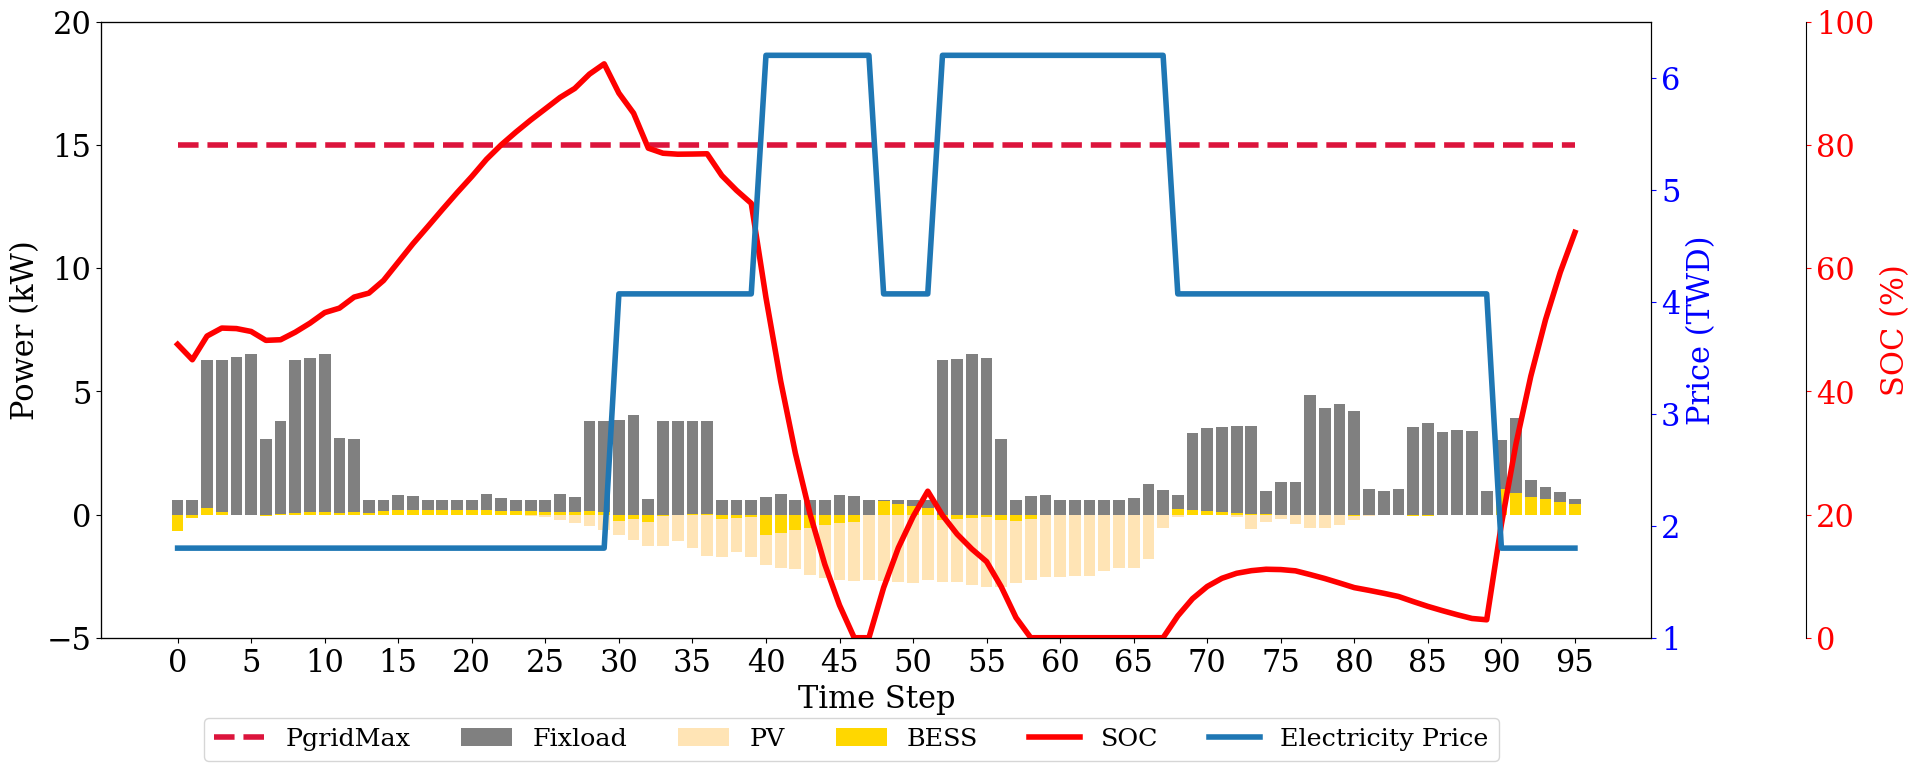

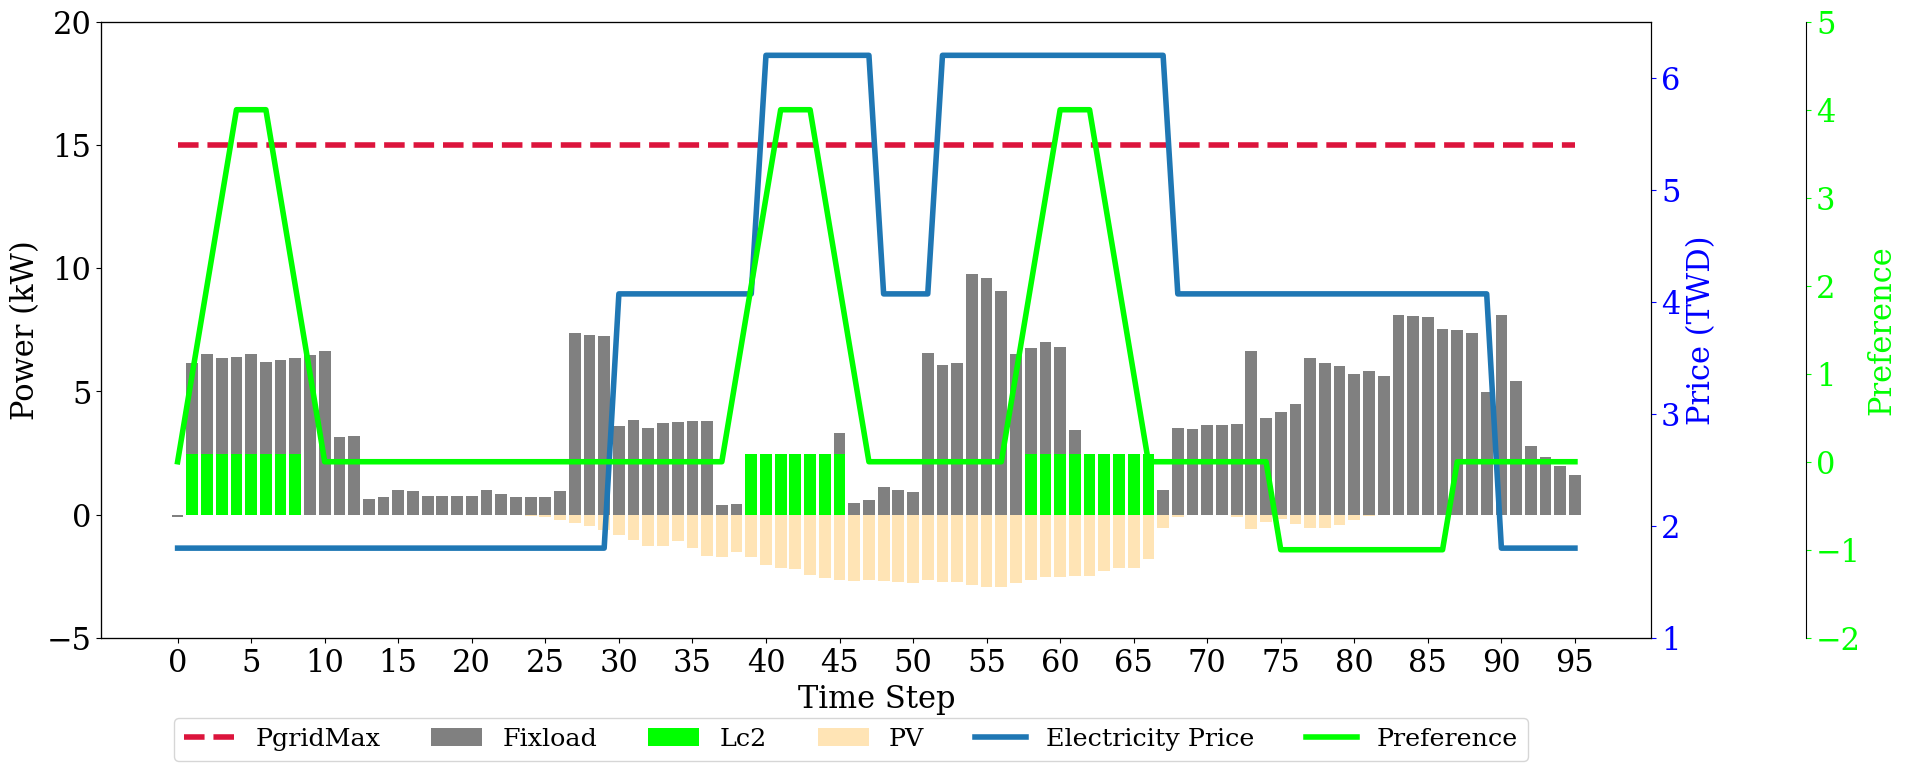

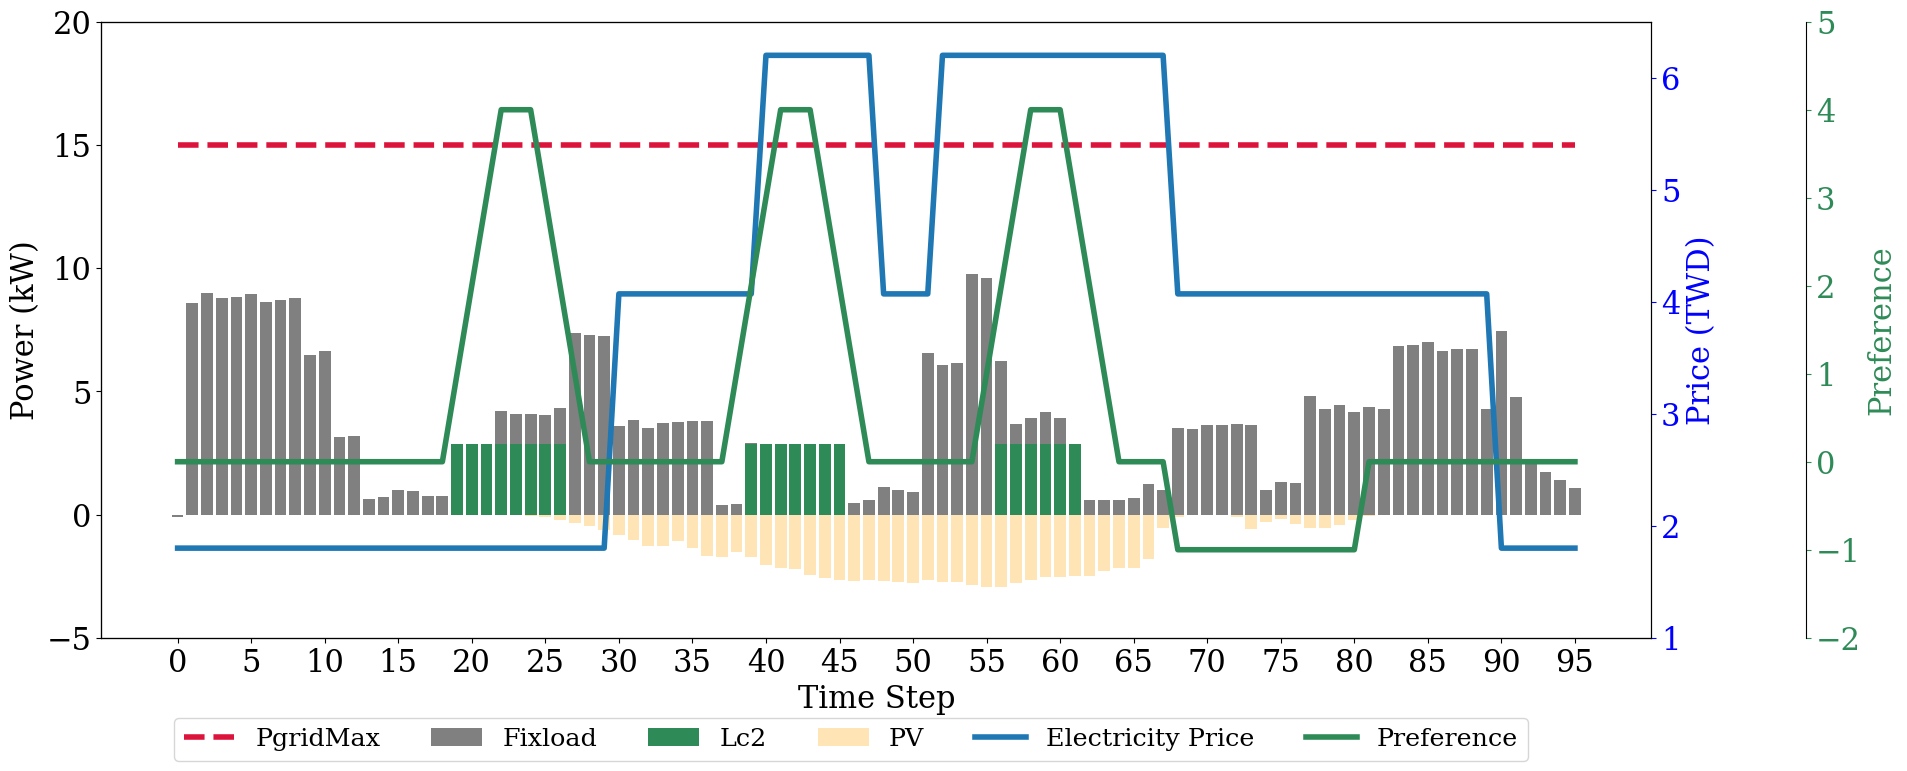

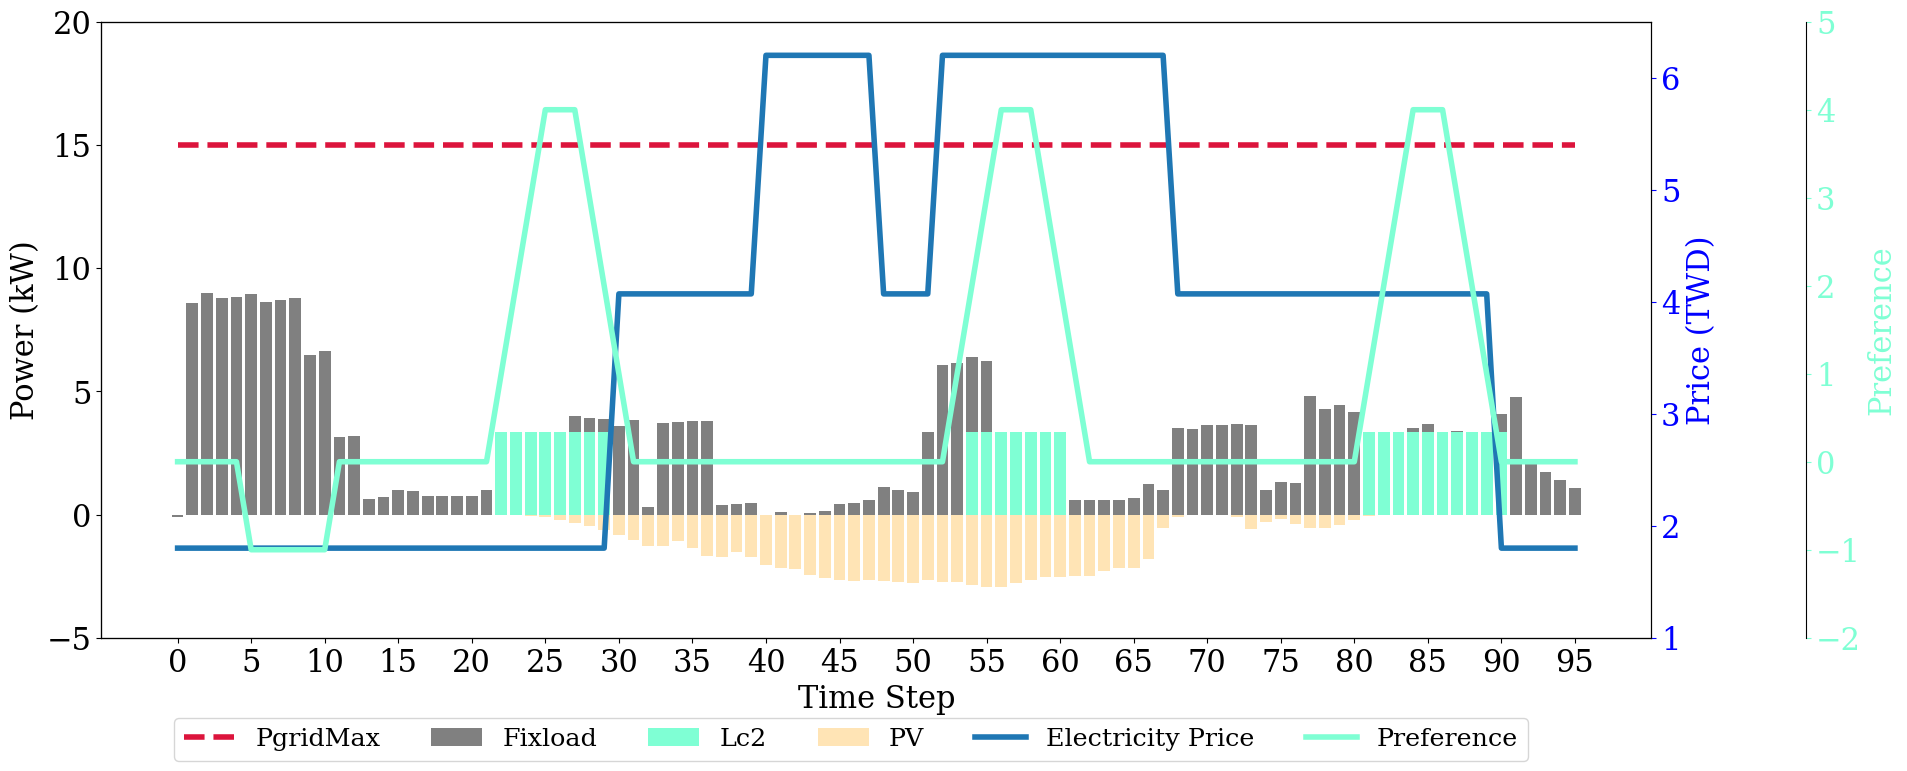

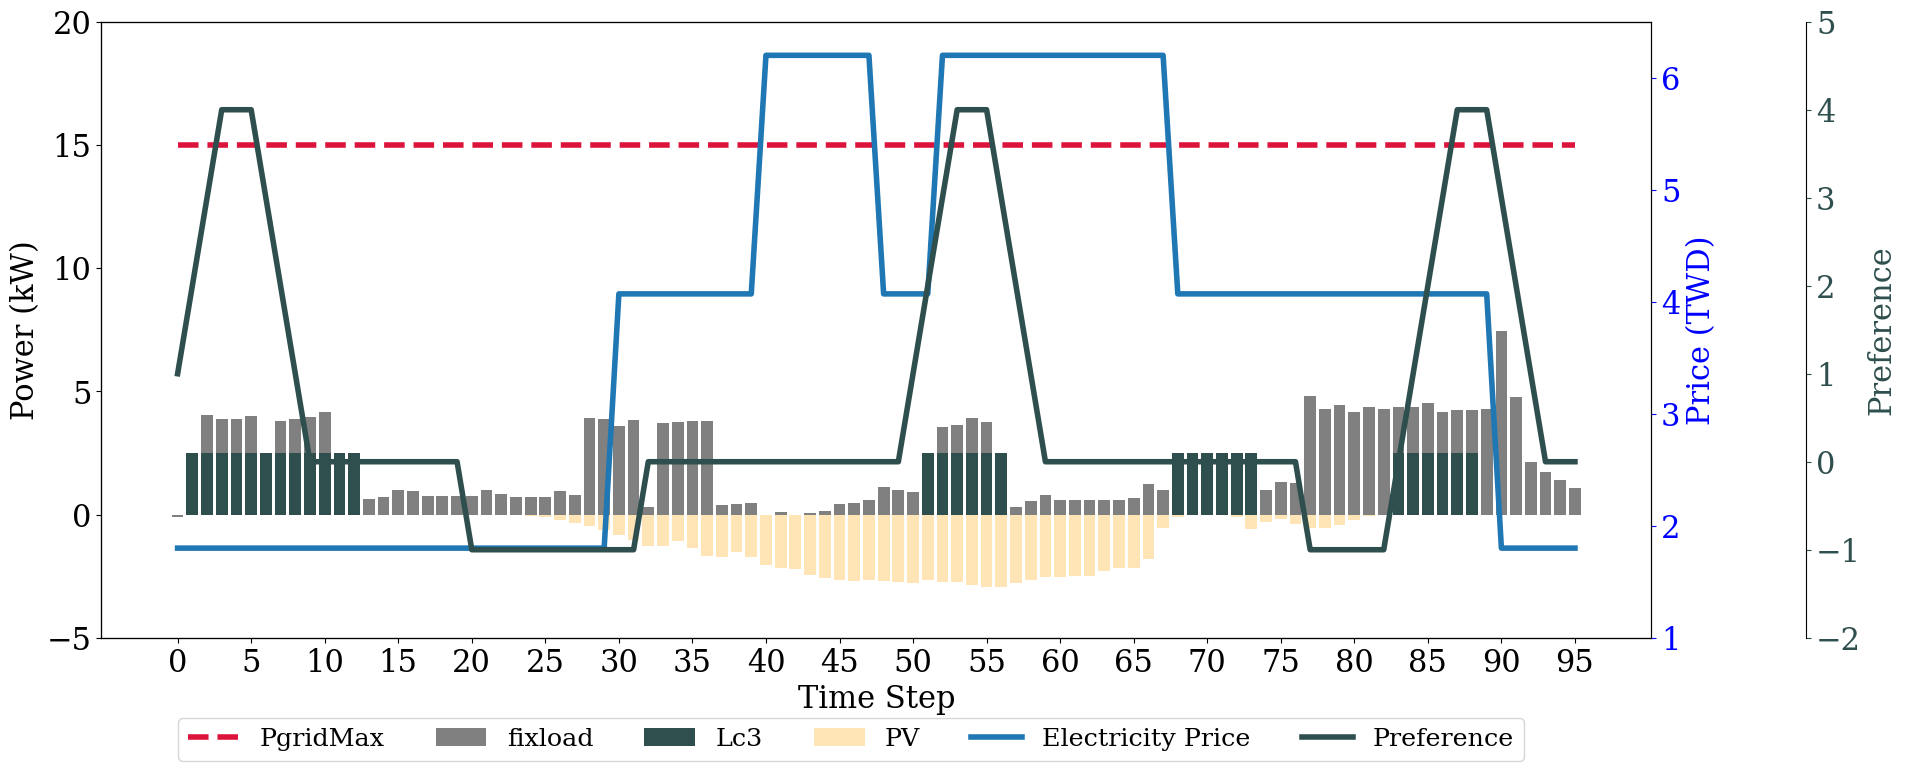

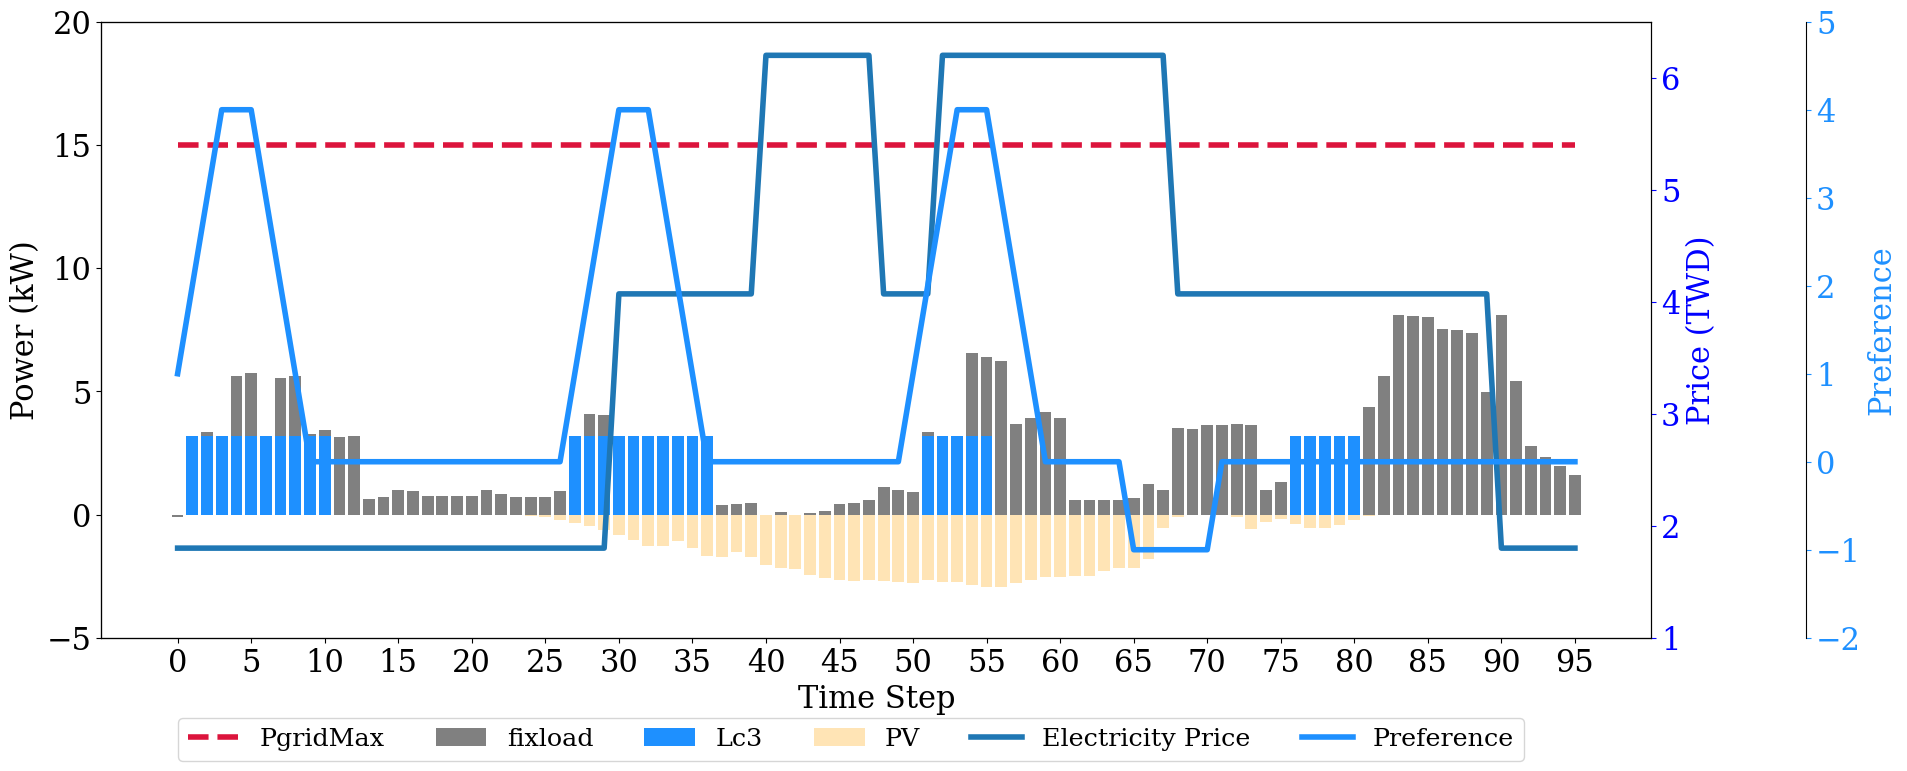

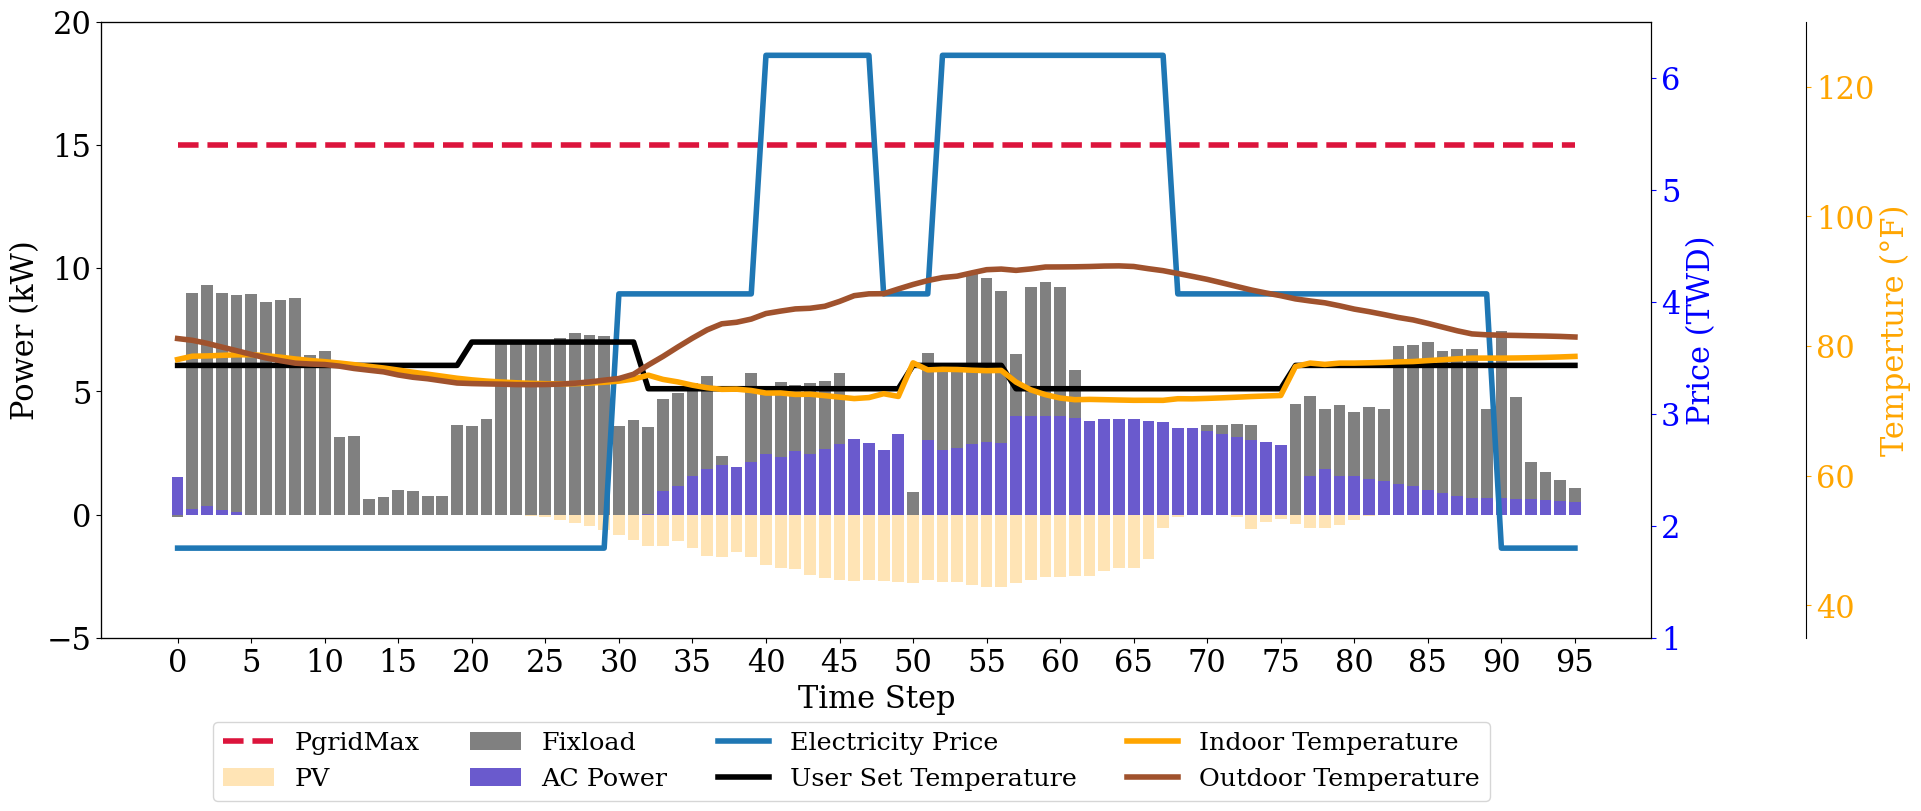

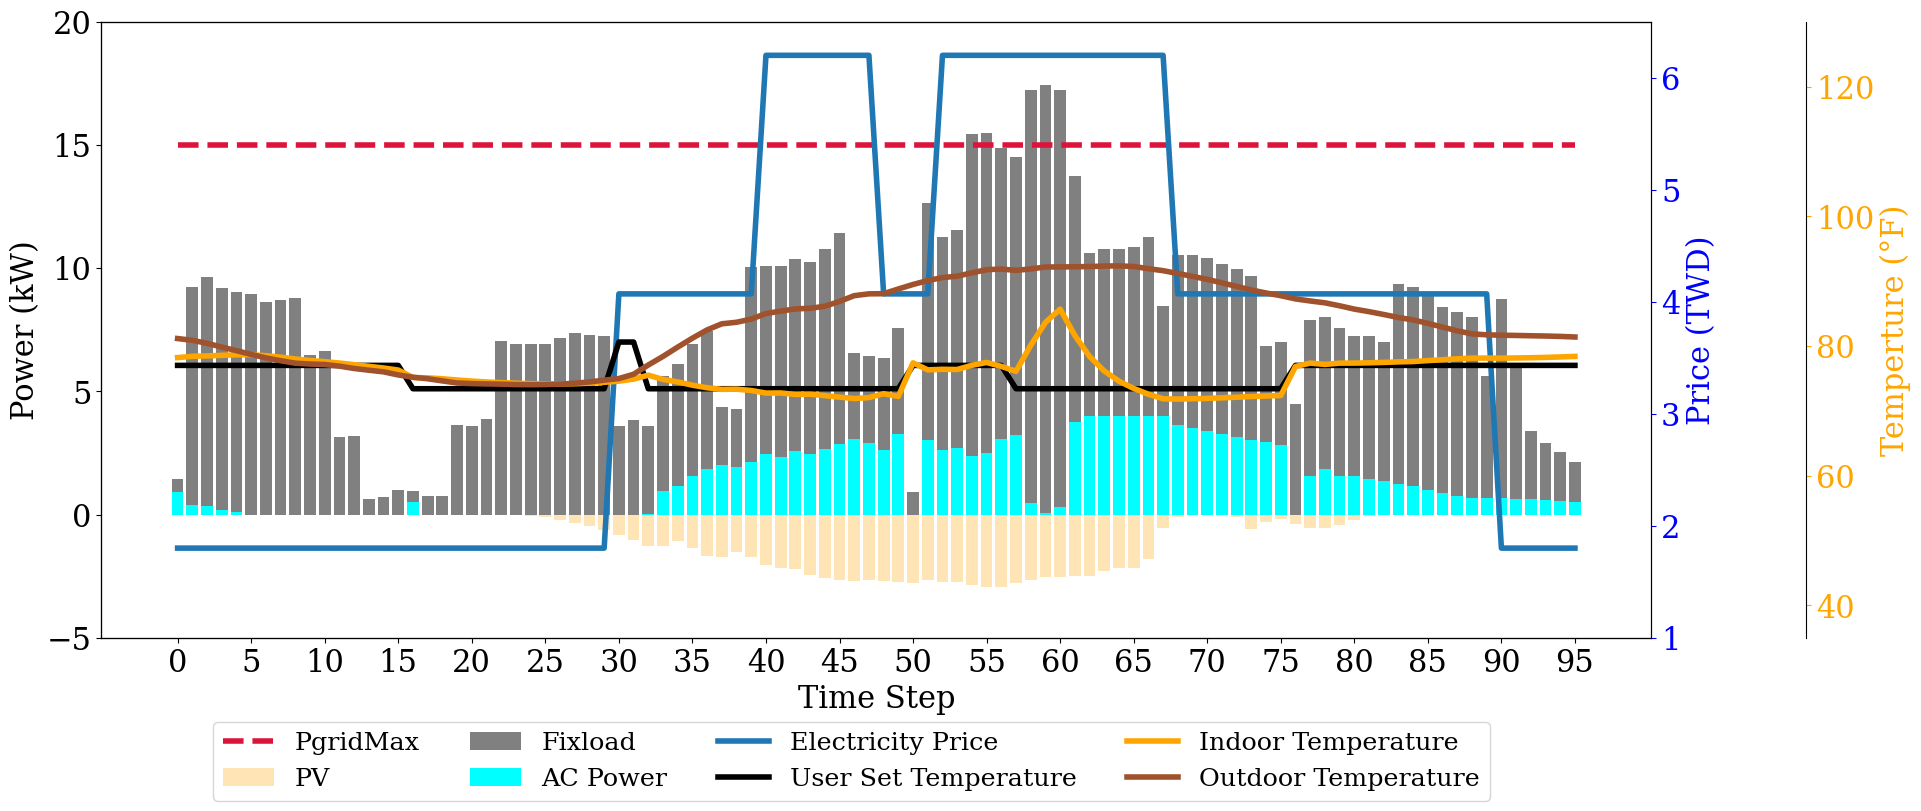

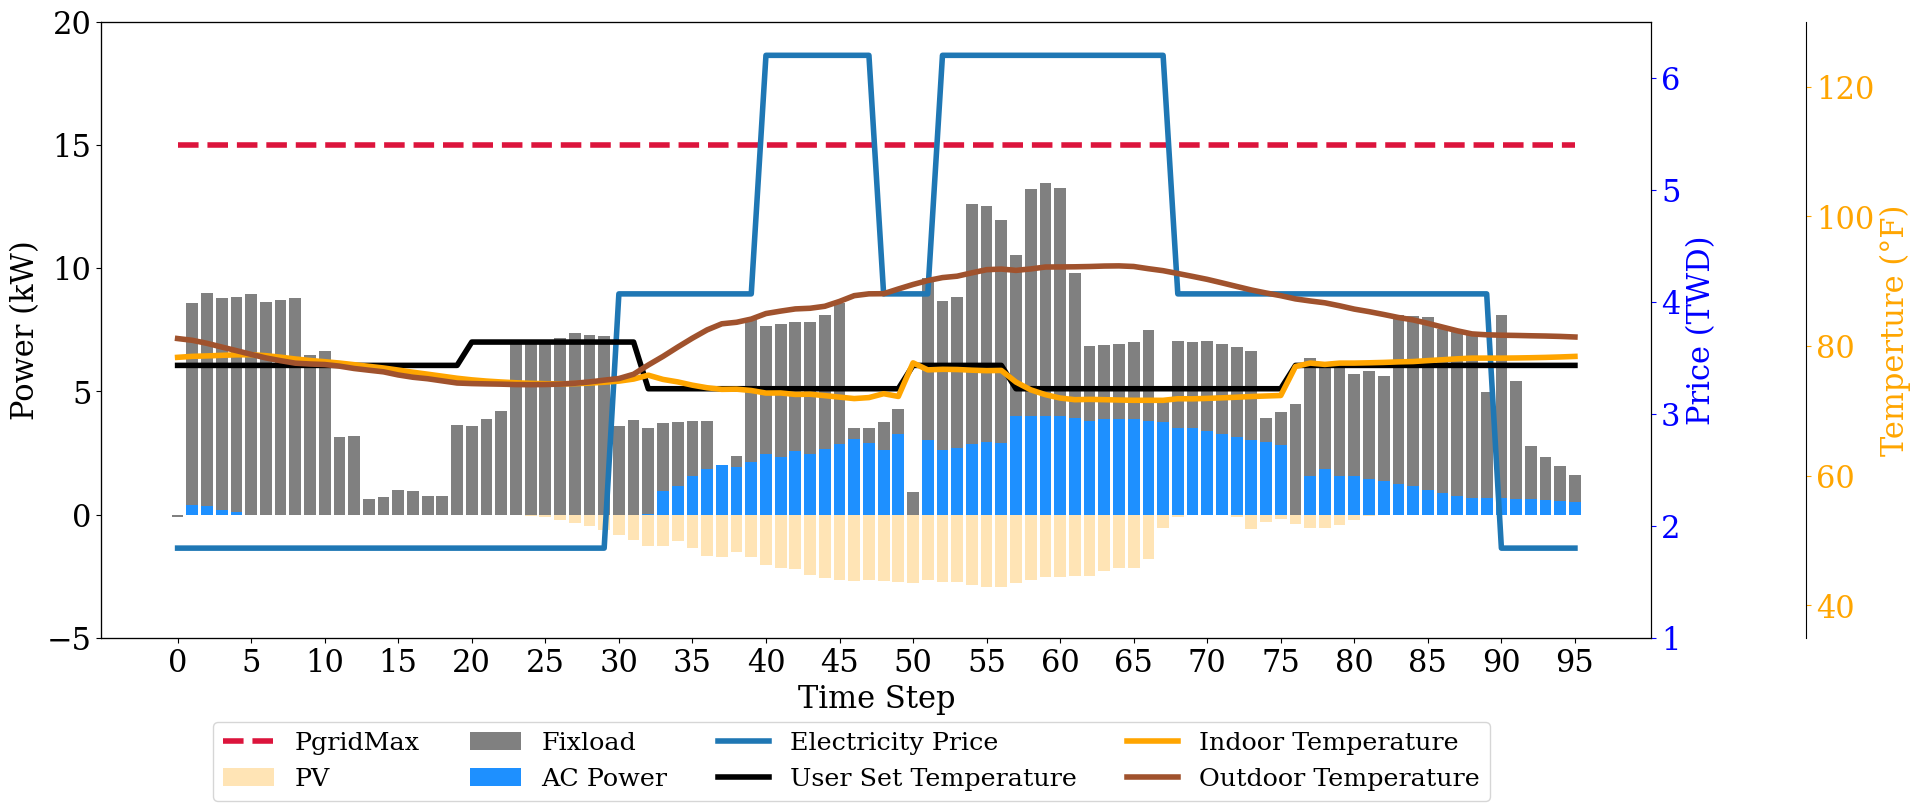

In [119]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

def plot_soc_load( month_title ):
    title = month_title + "_SOC"
    # plt.title(title)
    plt.rcParams["figure.figsize"] = (20, 8)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif']  = ['Times New Roman'] + plt.rcParams['font.serif']
    fig,axes = plt.subplots()
    x = np.arange(96)
    axes.set_xticks(x[::5])
    axes.set_xlabel('Time Step')
  
    #soc
    sub5 = axes.twinx()
    sub5.set_ylabel('SOC (%)',color='red')
    sub5.set_ylim(0,100)
    sub5.spines['right'].set_position(("axes",1.1))
    sub5.tick_params(axis='y',colors = 'red')
    sub5.plot( range(96), np.array(env.plt_data['soc'])*100, label = 'SOC', color = 'red', linewidth = 4 )

    # fixloadPower
    axes.set_ylabel('Power (kW)')
    axes.set_ylim(-5,20)
    axes.bar( range(96), np.array(env.plt_data['soc_fixload']) + np.array(env.plt_data['pv']), label = 'Fixload', color = 'gray' ) 

    #pgrid_max
    axes.plot( range(96), env.plt_data['Pgrid max'], label ='PgridMax', linestyle='--', color='crimson', linewidth = 4)
    
    # pv
    axes.bar( range(96), np.array(env.plt_data['pv'])*-1, label ='PV', color = 'moccasin' ) 
    axes.bar( range(96), np.array(env.plt_data['soc_action']), label ='BESS', color = 'gold' ) 

    #price
    sub = axes.twinx()
    sub.set_ylim(1,6.5)
    sub.set_ylabel('Price (TWD)',color='blue')
    sub.spines['right'].set_position(("axes",1))
    sub.tick_params(axis='y',colors = 'blue')
    sub.plot(  range(96), env.plt_data['Pgrid price'], label = "Electricity Price", linewidth = 4)  

    # set all legend    
    fig.legend(bbox_to_anchor=(0.5, -0.06), loc="lower center", fontsize='small', shadow=False, ncol=6)

    #save img
    desired_dpi = 300
    fig.savefig("plot/soc/"+ title + '.jpg', dpi=desired_dpi, bbox_inches='tight')

def plot_int_load( id, month_title ):
    title = month_title+"_Interruptable load_"+str(id)

    if id == 1:
        int_color = 'lime'
    elif id == 2:
        int_color = 'seagreen'
    else:
        int_color = 'aquamarine'

    # plot_int
    fig,axes = plt.subplots()
    plt.rcParams["figure.figsize"] = (20, 8)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    # plt.title(title)
    x = np.arange(96)
    axes.set_xticks(x[::5])
    axes.set_xlabel('Time Step')

    axes.set_ylim( -5, 20)
    axes.set_ylabel('Power (kW)')
    #Remain Power
    axes.bar( range(96), np.array(env.plt_data['int_'+str(id)+'_fixload']) + np.array(env.plt_data['pv']), label = 'Fixload', color = 'gray' ) 
    
    #Action
    axes.bar( range(96), env.plt_data['int_'+str(id)+'_power'], label = 'Lc2', color = int_color)  

    #pgrid_max
    axes.plot(range(96), env.plt_data['Pgrid max'], label ='PgridMax',linestyle='--',color='crimson', linewidth = 4)

    # pv
    axes.bar( range(96), np.array(env.plt_data['pv'])*-1, label ='PV', color = 'moccasin' ) 

    #price
    sub = axes.twinx()
    sub.set_ylim(1,6.5)
    sub.set_ylabel('Price (TWD)',color='blue')
    sub.spines['right'].set_position(("axes",1))
    sub.tick_params(axis='y',colors = 'blue')
    sub.plot(  range(96), env.plt_data['Pgrid price'], label = "Electricity Price", linewidth = 4)   

    #Preference
    sub5 = axes.twinx()
    sub5.set_ylim( -2, 5)
    sub5.set_ylabel( 'Preference', color = int_color )
    sub5.spines['right'].set_position( ( "axes", 1.1 ) )
    sub5.tick_params( axis = 'y', colors = int_color)
    sub5.plot( range(96), env.plt_data['int_'+str(id)+'_preference'], label = 'Preference', color = int_color, linewidth = 4)    
        
    # set all legend    
    fig.legend(bbox_to_anchor=(0.5, -0.06), loc="lower center", fontsize='small', shadow=False, ncol=6)

    #save img
    desired_dpi = 300
    fig.savefig("plot/int/"+ title + '.jpg', dpi=desired_dpi, bbox_inches='tight')

def plot_unint_load( id, month_title ): 
    title = month_title+"_Uninterruptable load_"+str(id)

    if id == 1:
        unint_color = 'darkslategray'
    else:
        unint_color = 'dodgerblue'

    # plot_uint
    fig,axes = plt.subplots()
    plt.rcParams["figure.figsize"] = (20, 8)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    # plt.title(title)
    x = np.arange(96)
    axes.set_xticks(x[::5])
    axes.set_xlabel('Time Step')

    #Remain Power
    axes.set_ylim( -5, 20)
    axes.set_ylabel('Power (kW)')

    axes.bar( range(96), np.array(env.plt_data['unint_'+str(id)+'_fixload']) + np.array(env.plt_data['pv']), label = 'fixload', color = 'gray' )  

    #Action
    axes.bar( range(96), env.plt_data['unint_'+str(id)+'_power'], label = 'Lc3', color =  unint_color)  

    #pgrid_max
    axes.plot( range(96), env.plt_data['Pgrid max'],label ='PgridMax',linestyle='--',color='crimson', linewidth = 4)

    # pv
    axes.bar( range(96), np.array(env.plt_data['pv'])*-1, label ='PV', color = 'moccasin', linewidth = 4) 

    #price
    sub = axes.twinx()
    sub.set_ylim(1,6.5)
    sub.set_ylabel('Price (TWD)',color='blue')
    sub.spines['right'].set_position(("axes",1))
    sub.tick_params(axis='y',colors = 'blue')
    sub.plot(  range(96), env.plt_data['Pgrid price'], label = "Electricity Price", linewidth = 4)  

    #Preference
    sub5 = axes.twinx()
    sub5.set_ylim( -2, 5)
    sub5.set_ylabel( 'Preference', color = unint_color )
    
    sub5.spines['right'].set_position( ( "axes", 1.1 ) )
    sub5.tick_params( axis = 'y', colors = unint_color)
    sub5.plot( range(96), env.plt_data['unint_'+str(id)+'_preference'], label = 'Preference', color = unint_color, linewidth = 4)    
        
    # set all legend    
    fig.legend(bbox_to_anchor=(0.5, -0.06), loc="lower center", fontsize='small', shadow=False, ncol=6)

    #save img
    desired_dpi = 300
    fig.savefig("plot/unint/"+ title + '.jpg', dpi=desired_dpi, bbox_inches='tight')

def plot_hvac_load( id, month_title):
    title = month_title+"_HVAC_"+str(id)
    
    if id == 1:
        hvac_color = 'slateblue'
    elif id == 2:
        hvac_color = 'aqua'
    else:
        hvac_color = 'dodgerblue'

    fig,axes = plt.subplots()
    # plt.title(title)
    plt.rcParams["figure.figsize"] = (20, 8)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    
    x = np.arange(96)
    axes.set_xlabel('Time Step')
    axes.set_xticks(x[::5])

    # power
    axes.set_ylabel('Power (kW)')
    axes.set_ylim(-5,20)
    
    #pgrid_max
    axes.plot( range(96), env.plt_data['Pgrid max'], label ='PgridMax', linestyle='--', color = 'crimson' , linewidth = 4)

    # pv
    axes.bar( range(96), np.array(env.plt_data['pv'])*-1, label ='PV', color = 'moccasin' ) 
    axes.bar( range(96), np.array(env.plt_data['hvac_'+str(id)+'_fixload']) + np.array(env.plt_data['pv']), label = 'Fixload', color = 'gray' ) 
           
    #Action
    axes.bar( range(96), env.plt_data['hvac_'+str(id)+'_power'], label = 'AC Power', color = hvac_color )   

    #price
    sub = axes.twinx()
    sub.set_ylim(1,6.5)
    sub.set_ylabel('Price (TWD)',color='blue')
    
    sub.spines['right'].set_position(("axes",1.0))
    sub.tick_params(axis='y',colors = 'blue')
    sub.plot(  range(96), env.plt_data['Pgrid price'], label = "Electricity Price", linewidth = 4)  

    # temperature
    sub5 = axes.twinx()
    sub5.set_ylim(35,130)
    sub5.set_ylabel('Temperture (°F)',color='orange')
    
    sub5.spines['right'].set_position(("axes",1.1))
    sub5.tick_params(axis='y',colors ='orange')
    #userSet
    sub5.plot( range(96), env.plt_data['T_set_'+str(id)], label = 'User Set Temperature', color ='black', linewidth = 4)

    #Indoor
    sub5.plot( range(96), env.plt_data['T_in_'+str(id)], label = 'Indoor Temperature', color ='orange', linewidth = 4)
    
    #Outdoor
    sub5.plot(range(96) , env.plt_data['T_out'],label = 'Outdoor Temperature', color ='sienna', linewidth = 4)

    # set all legend    
    fig.legend(bbox_to_anchor=(0.5, -0.11), loc="lower center", fontsize='small', shadow=False, ncol=4)

    #save img
    desired_dpi = 300
    fig.savefig("plot/hvac/"+ title + '.jpg', dpi=desired_dpi, bbox_inches='tight')

from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.utils import get_action_masks

month_name = {1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"}

model = MaskablePPO.load("hla_agent/HLA_model_order")

# env = HLA_Env(mode = 'test_print')
env = HLA_Env(mode = 'test')

month = 8

plt_dot = {}
for d in range(9):
    plt_dot[d] = []

month_title = month_name[month]
env.reset(day = month, Pgrid_max = 15)
total_rewards = 0

terminated = False

while not terminated:
    # env.render()
    action_masks = get_action_masks(env)
    action, _ = model.predict(state, action_masks=action_masks, deterministic=True)
    state, reward, terminated, _ , _ = env.step(action)
    # print(env.agent_order)
    order = int(env.agent_order)
    if order == 0 :
        order = 9
    plt_dot[int(action)].append(order)
    total_rewards += reward
    if terminated:
        break

int_load_remain = 0
unint_load_remain = 0

for id in range(1,4):
    int_load_remain += env.int_load[id].load_remain_demand

for id in range(1,3):
    unint_load_remain += env.unint_load[id].load_remain_demand

# print( 'total_reward :', total_rewards, '  total_cost :' ,env.total_cost, '  total_preference :', env.total_preference)
# print( 'int_load_remain :',int_load_remain, ' unint_load_remain :', unint_load_remain, ' last time_step soc :', env.soc_load.soc)

print('hvac  : ',env.hvac_preference)
print('int   : ',env.int_preference  , '   int_load_remain :', int_load_remain )
print('unint : ',env.unint_preference, ' unint_load_remain :', unint_load_remain)
print('total_cost :' ,env.total_cost/4)
print('total_preference :', env.total_preference)

plot_soc_load( month_title = month_title )

for id in range(1,4):
    plot_int_load( id = id, month_title = month_title )

for id in range(1,3):
    plot_unint_load( id = id, month_title = month_title )

for id in range(1,4):
    plot_hvac_load( id = id, month_title = month_title )



In [91]:
# baseline 2
# env = HLA_Env(mode = 'test')

month_title = month_name[month]
env.reset(day = month,Pgrid_max=15)
total_rewards = 0
terminated = False

# action_list = [0,4,5,1,2,3,6,7,8]
action_list = [1,2,3,4,5,6,7,8,0,]
# action_list = [1,2,3,4,5,6,7,8,0,]
action  = 0
counter = 0
while not terminated:
    action = action_list[counter]

    state, reward, terminated, _ , _ = env.step(action)

    total_rewards += reward
    if terminated:
        break

    counter += 1
    if counter >= 9:
        counter = 0

int_load_remain = 0
unint_load_remain = 0

for id in range(1,4):
    int_load_remain += env.int_load[id].load_remain_demand

for id in range(1,3):
    unint_load_remain += env.unint_load[id].load_remain_demand

print('baseline 2 ------------')
print('hvac  : ',env.hvac_preference)
print('int   : ',env.int_preference  , '   int_load_remain :', int_load_remain )
print('unint : ',env.unint_preference, ' unint_load_remain :', unint_load_remain)
print('total_cost :' ,env.total_cost/4)
print('total_preference :', env.total_preference)

# plot_soc_load( month_title = month_title )

# for id in range(1,4):
#     plot_int_load( id = id, month_title = month_title )

# for id in range(1,3):
#     plot_unint_load( id = id, month_title = month_title )

# for id in range(1,4):
#     plot_hvac_load( id = id, month_title = month_title )

# hvac  :  278.60623865835055
# int   :  185.0    int_load_remain : 0
# unint :  120.0  unint_load_remain : 0
# total_cost : 851.7989646356531
# total_preference : 583.6062386583501

baseline 2 ------------
hvac  :  311.6316940907661
int   :  185.0    int_load_remain : 0
unint :  120.0  unint_load_remain : 0
total_cost : 866.7561258635626
total_preference : 616.6316940907659


In [92]:
print('0 : ',np.array(plt_dot[0]))
print('1 : ',np.array(plt_dot[1]))
print('2 : ',np.array(plt_dot[2]))
print('3 : ',np.array(plt_dot[3]))
print('4 : ',np.array(plt_dot[4]))
print('5 : ',np.array(plt_dot[5]))
print('6 : ',np.array(plt_dot[6]))
print('7 : ',np.array(plt_dot[7]))
print('8 : ',np.array(plt_dot[8]))
# for a in range(9):
#     print('agent',a)
#     for i in range(96):
#         print(plt_dot[a][i])

0 :  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1 :  [5 4 4 4 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 5 4 4 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6]
2 :  [7 6 6 6 6 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 6 6 6 6 6 6 6 7 7 6 6 6 6 6
 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3]
3 :  [6 5 5 5 5 5 5 4 4 5 5 5 5 4 4 4 4 4 4 4 5 5 5 5 5 5 5 4 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
4 :  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 3 3 3 3 3 3 4 4 4 4 4 4 

In [93]:
for a in range(9):
    print('agent',a)
    for i in range(96):
        print(plt_dot[a][i])

agent 0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
agent 1
5
4
4
4
3
3
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
5
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
6
6
6
6
6
6
6
6
agent 2
7
6
6
6
6
7
7
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
6
6
6
6
6
6
6
7
7
6
6
6
6
6
6
6
6
6
6
6
6
6
5
5
5
5
5
5
5
5
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
3
3
agent 3
6
5
5
5
5
5
5
4
4
5
5
5
5
4
4
4
4
4
4
4
5
5
5
5
5
5
5
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
agent 4
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
